# COMP 551 Project 4 Kaggle MNIST

### Ran Cheng, 260768706   |   XXXX, XXXXXXX    |    XXXX, XXXXXXX

### Read Image

In [1]:
%matplotlib inline
# import data
import numpy   as np 
import scipy.misc # to visualize only  
x = np.loadtxt("./Data/train_x.csv", delimiter=",") # load from text 
y = np.loadtxt("./Data/train_y.csv", delimiter=",") 
x = x.reshape(-1, 64, 64) # reshape 
y = y.reshape(-1, 1)

### Pre-process Image

In [2]:
import math
import numpy as np
from skimage import measure
import matplotlib.pyplot as plt
from skimage.transform import resize

def preProcessing(img):
    #plt.imshow(img)
    img[img < 255] = 0
    img[img > 0] = 1
    # Find contours at a constant value of 0.8
    contours = measure.find_contours(img, 0.8)
    # Find the biggest contour as candidate digital image
    max_diff = -100
    max_contor = None
    for contor in contours:
        x_diff = max(contor[:,1]) - min(contor[:,1])
        y_diff = max(contor[:,0]) - min(contor[:,0])
        # print('contour[ %d]'%i,  'x_diff: %0.2f' % x_diff, 'y_diff: %0.2f' % y_diff)
        current_diff = max(x_diff, y_diff)
        if current_diff > max_diff:
            max_contor = contor
            max_diff = current_diff
    # Display the image and plot all contours found
    # fig, ax = plt.subplots()
    # ax.imshow(img, interpolation='nearest', cmap=plt.cm.gray)
    # ax.plot(max_contor[:, 1], max_contor[:, 0], linewidth=2)
    if max_contor is None:
        return resize(img, (16, 16), mode='wrap')
    box_x_s = math.floor(min(max_contor[:,1]))
    box_x_e = math.ceil(max(max_contor[:,1]))
    box_y_s = math.floor(min(max_contor[:,0]))
    box_y_e = math.ceil(max(max_contor[:,0]))
    img = img[box_y_s:box_y_e, box_x_s:box_x_e]
    img = resize(img, (16, 16), mode='wrap')
    return img

In [3]:
# import multiprocessing

# jobs = []
# for i in range(len(x)):
#     p = multiprocessing.Process(target=preProcessing, args=(x[i],))
#     jobs.append(p)
#     p.start()

In [4]:
X_train_raw = []
for i in range(len(x)):
    X_train_raw.append(preProcessing(x[i]))

In [5]:
#split data to train and test
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y, test_size=0.15, random_state=42)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

6.0


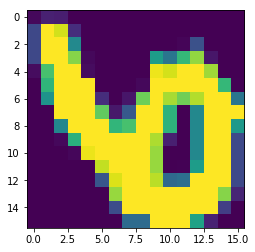

In [6]:
plt.imshow(X_test[23])
print(y_test[23])

### 1. Start With Baseline, Linear SVM

In [22]:
from sklearn import datasets, svm, metrics

############### Classification with grid search ##############
# If you don't want to wait, comment this section and uncommnet section below with
# standalone SVM classifier

# Create parameters grid for RBF kernel, we have to set C and gamma
from sklearn.model_selection import GridSearchCV
# generate matrix with all gammas
# [ [10^-4, 2*10^-4, 5*10^-4], 
#   [10^-3, 2*10^-3, 5*10^-3],
#   ......
#   [10^3, 2*10^3, 5*10^3] ]
#gamma_range = np.outer(np.logspace(-4, 3, 8),np.array([1,2, 5]))
gamma_range = np.outer(np.logspace(-3, 0, 4),np.array([1,5]))
gamma_range = gamma_range.flatten()

# generate matrix with all C
#C_range = np.outer(np.logspace(-3, 3, 7),np.array([1,2, 5]))
C_range = np.outer(np.logspace(-1, 1, 3),np.array([1,5]))
# flatten matrix, change to 1D numpy array
C_range = C_range.flatten()

parameters = {'kernel':['rbf'], 'C':C_range, 'gamma': gamma_range}

In [13]:
# reshape X data to 2d for linear fitting
X_train = np.asarray(X_train)
nsamples, nx, ny = X_train.shape
X_train = X_train.reshape((nsamples,nx*ny))
X_test = np.asarray(X_test)
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))

In [27]:
from matplotlib.colors import Normalize
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
def plot_param_space_scores(scores, C_range, gamma_range):
    """
    Draw heatmap of the validation accuracy as a function of gamma and C
    
    
    Parameters
    ----------
    scores - 2D numpy array with accuracies
    
    """
    #
    # The score are encoded as colors with the hot colormap which varies from dark
    # red to bright yellow. As the most interesting scores are all located in the
    # 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so
    # as to make it easier to visualize the small variations of score values in the
    # interesting range while not brutally collapsing all the low score values to
    # the same color.

    
    plt.figure(figsize=(8, 6))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.jet,
               norm=MidpointNormalize(vmin=0.5, midpoint=0.9))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
    plt.yticks(np.arange(len(C_range)), C_range)
    plt.title('Validation accuracy')  

In [11]:
import time
import datetime as dt

In [24]:

svm_clsf = svm.SVC()
grid_clsf = GridSearchCV(estimator=svm_clsf,param_grid=parameters,n_jobs=1, verbose=2)


start_time = dt.datetime.now()
print('Start param searching at {}'.format(str(start_time)))

grid_clsf.fit(X_train, y_train)

elapsed_time= dt.datetime.now() - start_time
print('Elapsed time, param searching {}'.format(str(elapsed_time)))
sorted(grid_clsf.cv_results_.keys())

classifier = grid_clsf.best_estimator_
params = grid_clsf.best_params_



scores = grid_clsf.cv_results_['mean_test_score'].reshape(len(C_range),
                                                     len(gamma_range))

plot_param_space_scores(scores, C_range, gamma_range)


######################### end grid section #############

Start param searching at 2018-03-09 01:31:50.882396
Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] gamma=0.001, C=0.1, kernel=rbf ..................................
[CV] ................... gamma=0.001, C=0.1, kernel=rbf, total= 9.7min
[CV] gamma=0.001, C=0.1, kernel=rbf ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 14.2min remaining:    0.0s


[CV] ................... gamma=0.001, C=0.1, kernel=rbf, total= 8.4min
[CV] gamma=0.001, C=0.1, kernel=rbf ..................................
[CV] ................... gamma=0.001, C=0.1, kernel=rbf, total= 8.4min
[CV] gamma=0.005, C=0.1, kernel=rbf ..................................
[CV] ................... gamma=0.005, C=0.1, kernel=rbf, total= 5.4min
[CV] gamma=0.005, C=0.1, kernel=rbf ..................................
[CV] ................... gamma=0.005, C=0.1, kernel=rbf, total= 5.4min
[CV] gamma=0.005, C=0.1, kernel=rbf ..................................
[CV] ................... gamma=0.005, C=0.1, kernel=rbf, total= 5.4min
[CV] gamma=0.01, C=0.1, kernel=rbf ...................................
[CV] .................... gamma=0.01, C=0.1, kernel=rbf, total= 4.6min
[CV] gamma=0.01, C=0.1, kernel=rbf ...................................
[CV] .................... gamma=0.01, C=0.1, kernel=rbf, total= 4.6min
[CV] gamma=0.01, C=0.1, kernel=rbf ...................................
[CV] .

[CV] .................... gamma=0.05, C=1.0, kernel=rbf, total= 3.7min
[CV] gamma=0.1, C=1.0, kernel=rbf ....................................
[CV] ..................... gamma=0.1, C=1.0, kernel=rbf, total= 8.0min
[CV] gamma=0.1, C=1.0, kernel=rbf ....................................
[CV] ..................... gamma=0.1, C=1.0, kernel=rbf, total= 8.0min
[CV] gamma=0.1, C=1.0, kernel=rbf ....................................
[CV] ..................... gamma=0.1, C=1.0, kernel=rbf, total= 8.1min
[CV] gamma=0.5, C=1.0, kernel=rbf ....................................
[CV] ..................... gamma=0.5, C=1.0, kernel=rbf, total=14.0min
[CV] gamma=0.5, C=1.0, kernel=rbf ....................................
[CV] ..................... gamma=0.5, C=1.0, kernel=rbf, total=14.0min
[CV] gamma=0.5, C=1.0, kernel=rbf ....................................
[CV] ..................... gamma=0.5, C=1.0, kernel=rbf, total=14.0min
[CV] gamma=1.0, C=1.0, kernel=rbf ....................................
[CV] .

[CV] .................... gamma=5.0, C=10.0, kernel=rbf, total=13.6min
[CV] gamma=5.0, C=10.0, kernel=rbf ...................................
[CV] .................... gamma=5.0, C=10.0, kernel=rbf, total=13.8min
[CV] gamma=5.0, C=10.0, kernel=rbf ...................................
[CV] .................... gamma=5.0, C=10.0, kernel=rbf, total=13.8min
[CV] gamma=0.001, C=50.0, kernel=rbf .................................
[CV] .................. gamma=0.001, C=50.0, kernel=rbf, total= 2.6min
[CV] gamma=0.001, C=50.0, kernel=rbf .................................
[CV] .................. gamma=0.001, C=50.0, kernel=rbf, total= 2.6min
[CV] gamma=0.001, C=50.0, kernel=rbf .................................
[CV] .................. gamma=0.001, C=50.0, kernel=rbf, total= 2.6min
[CV] gamma=0.005, C=50.0, kernel=rbf .................................
[CV] .................. gamma=0.005, C=50.0, kernel=rbf, total= 2.4min
[CV] gamma=0.005, C=50.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed: 1677.2min finished


Elapsed time, param searching 1 day, 4:02:38.595454


NameError: name 'MidpointNormalize' is not defined

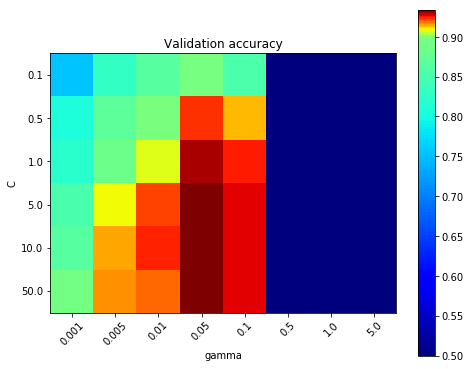

In [28]:

plot_param_space_scores(scores, C_range, gamma_range)

In [14]:
################ Classifier with good params ###########
# Create a classifier: a support vector classifier
from sklearn import datasets, svm, metrics
param_C = 5
param_gamma = 0.05
classifier = svm.SVC(C=param_C,gamma=param_gamma)

# We learn the digits on train part
start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))
classifier.fit(X_train, y_train)
end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

########################################################

Start learning at 2018-03-09 00:56:52.907149
Stop learning 2018-03-09 01:04:23.296147
Elapsed learning 0:07:30.388998


In [20]:
predict_y = classifier.predict(X_test)

In [19]:
mse_test = metrics.mean_squared_error(y_test, predict_y)
f1_test = metrics.f1_score(y_test, predict_y,average='macro')
print('MSE: %0.3f' %mse_test)
print('F1 Score: %0.3f' %f1_test)

MSE: 1.062
F1 Score: 0.939


## Q2 Feed Forward NN with BP

In [26]:
# the progress meter widget
from tqdm import tqdm
import numpy 
import math
import scipy.special

# define the Feed Forward NN:
class NeuralNetwork:
    # initialization
    # dims -> dimenison of the neural network architecture: [64*64 100 10] This is one hidden layer with 100 HU.
    # alpha -> learning rate
    # decay -> l1 weight decay
    # activation_func -> activation function //!!! maybe better to use LeRU for each layer ****TODO******
    # activation_func_prime -> differential activation function
    def __init__(self, dims, alpha, decay, activation_func, activation_func_prime):
        self.layers = [] # contain all layers of neurons.
        # hidden layer:
        for i in range(1, len(dims)):
            # hidden layer weight list for each hidden layer
            hiddenlayer_weights = []
            # for each layer, and each neuron, they contains the last layer's weight combination
            # the number of weight that the current neuron pocessessed is equal to the last layer's number:
            for j in range(dims[i]):
                # unifying the weight distribution between [-1,1]
                hiddenlayer_weights.append(numpy.random.uniform(-1, 1, dims[i - 1]))
            hiddenlayer_weights = numpy.array(hiddenlayer_weights)
            self.layers.append((hiddenlayer_weights))
        self.alpha = alpha
        self.weight_decay = decay
        self.f = activation_func
        self.f_prime = activation_func_prime
        
    # feed forward
    def feedForward(self, inputs):
        # loop through the layers and produce the output from the production of last layer
        # inputs and the current neurons' weight lists
        layer_outputs = []
        # loop layers of weights:
        for i in range(len(self.layers)):
            if i == 0:
                # first layer should be the input layer
                current_output = self.f(numpy.dot(self.layers[i], inputs))
            else:
                # other layer's input should be the last layer's output
                current_output = self.f(numpy.dot(self.layers[i], layer_outputs[i-1]))
            current_output = numpy.array(current_output)
            layer_outputs.append(current_output)
        return layer_outputs
        
    # back propogation
    def backPropagation(self, inputs, targets):
        # implement the BP:
        # for each layer we adjust the weight list according to the error function
        # conversion of inputs and target arrays to transposed numpy matrixes
        inputs = numpy.transpose(numpy.array([numpy.array(inputs)]))
        targets = numpy.transpose(numpy.array([numpy.array(targets)]))
        # outputs of each layer, we need all the layer's data to perform BP
        outputs = self.feedForward(inputs)
        # get error from the last layer output and target
        outErr = targets - outputs[len(outputs) - 1]
        # initialize hidden layer errors for each HU
        HiddenErrs = [None] * (len(outputs) - 1)
        # loop backward to update the previous layer's error
        for i in reversed(range(len(outputs) - 1)):
            HiddenErr = 0
            if i == len(outputs) - 2:
                # from the output error
                hiddenErr = numpy.dot(numpy.transpose(self.layers[i + 1]), outErr)
            else:
                # from 'back' layer
                hiddenErr = numpy.dot(numpy.transpose(self.layers[i + 1]), hiddenErrs[i + 1])
            HiddenErrs[i] = hiddenErr
        # update the weights using l1 weight decay
        for i in reversed(range(len(self.layers))):
            if i == len(self.layers) - 1:
                self.layers[i] += (self.alpha * numpy.dot((outErr * self.f_prime(outputs[i])), numpy.transpose(outputs[i - 1]))) + (self.alpha * self.weight_decay * self.layers[i])
            elif i == 0:
                self.layers[i] += (self.alpha * numpy.dot((HiddenErrs[i] * self.f_prime(outputs[i])), numpy.transpose(inputs))) + (self.alpha * self.weight_decay * self.layers[i])
            else:
                self.layers[i] += (self.alpha * numpy.dot((HiddenErrs[i] * self.f_prime(outputs[i])), numpy.transpose(outputs[i - 1]))) + (self.alpha * self.weight_decay * self.layers[i])

    # train
    def train(self, inputs, targets):
        self.backPropagation(inputs, targets)
        
    def query(self, inputs):
        inputs = numpy.transpose(numpy.array([numpy.array(inputs)]))
        return self.feedForward(inputs)[-1]

In [27]:
# test of the neural network
nn = NeuralNetwork([2, 2, 1], 0.01, 0.001, lambda x: scipy.special.expit(x), lambda x: x * (1 - x))
for i in tqdm(range(100000)):
    nn.train([0, 0], [0])
    nn.train([0, 1], [0])
    nn.train([1, 1], [1])
    nn.train([1, 0], [0])
    nn.train([1, 1], [1])

print(nn.query([0, 1]))
print(nn.query([1, 1]))
print(nn.query([1, 0]))
print(nn.query([0, 0]))


100%|██████████| 100000/100000 [00:15<00:00, 6601.07it/s]


[[0.5]]
[[1.]]
[[1.22776583e-159]]
[[3.50394896e-80]]


In [22]:
# create the encoding from the label, translate digits into binary vectors.
def encodingLabel(num):
    encode = []
    # init with 0s
    for i in range(10):
        encode.append(0)
    encode[num] = 1
    return encode
def encodeLabelWrapper(labels):
    for i in range(len(labels)):
        if i == 0:
            print(type(labels[i]))
        labels[i] = encodingLabel(labels[i])
    return labels
def kFoldsPreperation(images_train, labels_train):
    dataPerFold = int(len(images_train) / 10)

    imageFolds = []

    labelFolds = []

    iFold = []
    lFold = []
    for i in range(len(images_train)):
        iFold.append(images_train[i])
        lFold.append(labels_train[i])
        # if i is a multiple of the datafold then we add the fold to the folds layer
        # because only a number divisible by 5000 means it is a multiple of 5000
        # like 5000 * 2, 5000 * 3, etc
        # 0 mod anything is 0 so I check for that
        if i != 0 and i % dataPerFold == 0:
            # we append the fold to the folds arrays
            imageFolds.append(iFold)
            labelFolds.append(lFold)
            # and we empty out the iFold and lFold array for new dataset to be filled
            iFold = []
            lFold = []

    return (imageFolds, labelFolds)

def train(nn, imageFolds, labelFolds):
    # pick a random number, the index that gets tested that round won't be tested again ever
    # and gets placed in an array of indexes that has already been tested
    indexesTested = [] # contains the indexes from the folds array for which data has been tested

    # will contain values 0 to imageFolds
    pool = []
    for i in range(len(imageFolds)):
        pool.append(i)

    # holds the array of all the percentages that were obtained while training
    percentageList = []

    # we loop till the indexesTested is not equal to 10
    while len(indexesTested) != len(imageFolds):
        # selects a random number from a pool of 0 to 9 values
        poolIndex = random.randint(0, len(pool) - 1)
        randomIndex = pool[poolIndex]
        # after that specific value is picked from 0 to 9 we delete the value from pool so that it cannot be
        # selected again
        del pool[poolIndex]

        print("Training on folds....")
        for i in range(len(imageFolds)):
            # if i equals the randomIndex we skip the loop
            if i == randomIndex:
                continue
            for j in tqdm(range(len(imageFolds[i]))):
                nn.train(imageFolds[i][j], labelFolds[i][j])


        # now we test the randomIndex selected from the k folds
        print("Testing on a random fold at index {}....".format(randomIndex))
        accuracy = 0
        for i in tqdm(range(len(imageFolds[randomIndex]))):
            result = nn.query(imageFolds[randomIndex][i])
            result = result.tolist()

            if (result.index(max(result)) == labelFolds[randomIndex][i].index(max(labelFolds[randomIndex][i]))):
                accuracy += 1

        # at the end of the for loop we find the accuracy in percentage

        percentageAccuracy = (accuracy / len(imageFolds[randomIndex])) * 100

        print("Accuracy of Neural Network at the moment... {}%".format(percentageAccuracy))

        indexesTested.append(randomIndex)

        percentageList.append(percentageAccuracy)

    summation = 0
    for i in range(len(percentageList)):
        summation += percentageList[i]

    mean = summation / len(percentageList)

    print("Overall accuracy of the Neural Network is... {}%".format(mean))


In [19]:
y[0]

[4.0]

In [24]:
# train Neural Networks:
y = y.tolist()
y = [int(i) for i in y]
X_train_nn = [img.reshape(256,).tolist() for img in X_train_raw]
label_train = encodeLabelWrapper(y)
imageFolds, labelFolds = kFoldsPreperation(X_train_nn, label_train)

<class 'int'>


In [28]:
import random
nn = NeuralNetwork([256, 200, 10], 0.01, 0.001, lambda x: scipy.special.expit(x), lambda x: x * (1 - x))
train(nn, imageFolds, labelFolds)

Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4426.16it/s]


Testing on a random fold at index 8....


100%|██████████| 5000/5000 [00:00<00:00, 19403.81it/s]


Accuracy of Neural Network at the moment... 80.64%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4485.32it/s]


Testing on a random fold at index 3....


100%|██████████| 5000/5000 [00:00<00:00, 19858.02it/s]


Accuracy of Neural Network at the moment... 80.78%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4423.93it/s]


Testing on a random fold at index 7....


100%|██████████| 5000/5000 [00:00<00:00, 19950.08it/s]


Accuracy of Neural Network at the moment... 81.44%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4425.00it/s]


Testing on a random fold at index 6....


100%|██████████| 5000/5000 [00:00<00:00, 19815.09it/s]


Accuracy of Neural Network at the moment... 81.10000000000001%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4438.99it/s]


Testing on a random fold at index 0....


100%|██████████| 5001/5001 [00:00<00:00, 19641.93it/s]


Accuracy of Neural Network at the moment... 81.22375524895021%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4416.75it/s]


Testing on a random fold at index 5....


100%|██████████| 5000/5000 [00:00<00:00, 20023.16it/s]


Accuracy of Neural Network at the moment... 81.52000000000001%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4340.83it/s]


Testing on a random fold at index 4....


100%|██████████| 5000/5000 [00:00<00:00, 18676.05it/s]


Accuracy of Neural Network at the moment... 81.62%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4399.09it/s]


Testing on a random fold at index 1....


100%|██████████| 5000/5000 [00:00<00:00, 19704.65it/s]


Accuracy of Neural Network at the moment... 80.32000000000001%
Training on folds....


100%|██████████| 5000/5000 [00:01<00:00, 4144.95it/s]


Testing on a random fold at index 2....


100%|██████████| 5000/5000 [00:00<00:00, 20434.32it/s]


Accuracy of Neural Network at the moment... 81.3%
Overall accuracy of the Neural Network is... 81.10486169432781%
